<a href="https://colab.research.google.com/github/vicentcamison/idal_ia3/blob/main/MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Perceptrón Multi-Capa

En este *Notebook* vamos a implementar un Perceptron Multi-Capa (MLP: *Multilayer Perceptron*) para una tarea de clasificación: 

Para ello, vamos a crear nuestro propio conjunto de datos sintético

**RECUERDA**

En el perceptron multicapa, la salida de cada capa es calculada usando las activaciones de las capas anteriores de la siguiente manera.

$$h_{i} = \sigma(W_i h_{i-1} + b_i)$$

Dónde ${h}_i$ es el vector de activación de la $i$-ésima capa (o los datos de entrada para $i=0$), ${W}_i$ y ${b}_i$ son la matriz de pesos y el vector de sesgo (*bias*) para la capa $i$-ésima respectivamente

<br><rb>
$\sigma(\cdot)$ es la función de activación. En nuestro ejemplo usaremos la función de activación *Sigmoide* para las capas ocultas (intermedias) y la *softmax* para la última capa, dado que se trata de un problema de clasificación.


## Creación del conjunto de datos sintético
Lo primero que vamos a hacer es crear una función para generar datos sintéticos aletorios. Debes rellenar el siguiente código. Para ello, crea 2 nubes de puntos de 3 dimensiones (una para casa clase). La primera nube (800 puntos) que provenga de una distribución normal con media 0 y desviación estándar 1. La segunda nube de puntos (500 puntos), que sea igual que la primera pero que la última componente tenga media 3 y desviación estándar 0.5. Debes crear un vector de salida con valor 0 para la primera nube de puntos y 1 para la segunda. 

In [55]:
import numpy as np
import sys
import matplotlib.pyplot as plt

def generate_dataset(output_dim=3, num_examples=[800, 500]):
    features_class1 = np.random.normal(0, 1, [num_examples[0], output_dim])
    features_class2 = np.random.normal(0, 1, [num_examples[1], output_dim]) #hacemos una columna más de las necesarias
    features_class2[:, -1] = np.random.normal(3, 0.5, num_examples[1]) #sobreescribimos la columna adicional con estos valores con media diferente y desviación diferente
    x = np.concatenate((features_class1, features_class2), axis=0)

    labels_class1 = np.zeros((num_examples[0], 1))
    labels_class2 = np.ones((num_examples[1], 1))
    y = np.concatenate((labels_class1, labels_class2), axis=0)
    return (x, y)

# Es interesante que para numpy no es lo mismo un array de [800, 1] que uno de [800], de la misma forma que no es lo mismo una serie de pandas que un dataframe
# Me ha estado dando error el código de y[:, -1] precisamente por eso: es uno de [800]: por lo tanto, no tengo que hacer referencia a arrays multidimensionales,
#  hay que poner num_examples[1] en la dimensión, y no [num_examples[1], 1]

# Por otro lado, me parece interesante escribir esto por aquí, que he estado trabajando con esto:
# So, when you do [:, -1] it means you are taking all the rows and only the last column. -1 represents the last column.
# When you do [:, :-1], it means you are taking all the rows and all the columns except the last column.

Ahora vamos a llamar a la función anterior para generar nuestro conjunto de datos:

In [56]:
np.random.seed(1)
num_examples = [500,800]
output_dim = 3
x, y = generate_dataset(num_examples=num_examples, output_dim=output_dim)


In [58]:
x

array([[ 1.62434536, -0.61175641, -0.52817175],
       [-1.07296862,  0.86540763, -2.3015387 ],
       [ 1.74481176, -0.7612069 ,  0.3190391 ],
       ...,
       [ 1.06559062,  0.70165443,  2.81695081],
       [ 0.28887841,  0.88259776,  2.46943507],
       [-1.59121638,  0.59518926,  3.46946356]])

A continuación, representa los datos en 3D, con diferentes colores para representar la pertenencia a cada una de las clases:

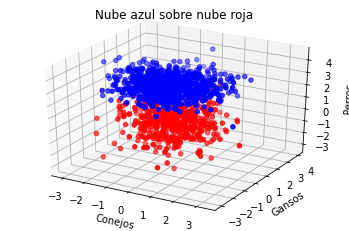

In [69]:
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:500, 0], x[:500, 1], x[:500, 2], c='r', marker='o')
ax.scatter(x[500:, 0], x[500:, 1], x[500:, 2], c='b', marker='o')

ax.set_xlabel('Conejos')
ax.set_ylabel('Gansos')
ax.set_zlabel('Perros')
ax.set_title('Nube azul sobre nube roja')

plt.show()

## Función de activación y su derivada

A continuación vamos a crear dos métodos. El primero implementará la función de activación correspondiente a la sigmoide. Esta función es necesaria para el cáculo *forward pass* de la red.  Dado un valor "x", esta función deberá cacular el valor con respecto a la siguiente fórmula:
$$a(x) =  \frac{\mathrm{1} }{\mathrm{1} + e^{-x}}$$

El segundo método, implementará la derivada de la función anterior, necesaria para el *backward pass*. Procediendo con la derivada, obtenemos las siguiente fórmula:

$${a}' = a(1-a)$$



In [79]:
def sigmoid(x):
  sig = 1 / (1 + np.exp(-x))
  return sig

In [80]:
def sigmoid_out2deriv(out):
  deriv_sig = out * (1 - out)
  return deriv_sig

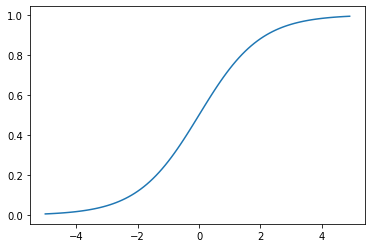

In [81]:
#Ploteamos la sigmoide para verla
a = np.arange(-5, 5, 0.1)
plt.plot(a, sigmoid(a))

## Contruyendo la Red Neuronal Artificial
A continuación vamos a definir la clase Layer. Ésta implementará los 3 métodos necesarios para entrenar la red neuronal (*forward*, *backward* y *update*). Recuerda que el `__init__` debe generar los pesos ${W}$ y ${b}$  de manera aleatoria. Para ello, utiliza una distribución normal con media -0.1 y desviación estándar 0.2.

<br><rb>
Para el cáculo del *backward pass* hay que calcular las derivadas parciales del coste (error) con respecto a cada uno de los parámetros de la red (${W}$ y ${b}$). Para ello, en esta clase solamente vamos a declarar las derivadas de las capas intermedias (las derivadas parciales de la última capa, que se calculan de manera distinta, las calcularemos fuera de esta clase. Los $\delta$ de los ${W}$ se calculan en función de los $\delta$ de la capa anterior:

$$ \delta^{l-1} = W^{l}\delta^{l}\frac{\partial a^{l-1}}{\partial z^{l-1}}$$

Donde $a$ es la función de activación, $z$ es la salida de la suma ponderada de la entrada (la salida de la neurona, la regresión lineal, antes de aplicar la función de activación) y $l-1$ hace referencia a la "*Layer*" anterior.

<br><rb>
 De ahí, que el método `backward` tenga compo parámetro de entrada la variable `output_delta` (correspondiente a los $\delta$ de la capa anterior). Para el cálculo de $\delta$ de los parámetros ${W}$ la capa actual hemos de realizar dos operaciones. La primera es multiplicar el $\delta$ de la capa posterior (que proviene del parámetro de entrada `output_delta`) por la derivada de la función de activación aplicada sobre la salida de la red en el *forward pass*. La segunda operación es el producto del resultado anterior por los pesos ${W}$.

<br><rb>
Para actualizar la red (método `update`) deberemos actualizar los pesos ${W}$ con un nuevo valor de la siguiente manera:
$$W_{i}(t)\:=\:W_{i}(t-1) - \alpha(\frac{\partial error}{\partial W_{i}})$$

Siendo $(\frac{\partial error}{\partial W_{i}})$ la derivada de la función de activación aplicada sobre la salida de la red en el forward pass (calculada en el método `backward`).


In [82]:

class Layer(object):
    def __init__(self, input_dim, output_dim, activation_func, act_func_deriv):
      self.weights = np.random.randn(output_dim, input_dim) * 0.2 - 0.1
      self.bias = np.random.randn(output_dim) * 0.2 - 0.1
      self.activation_func = activation_func
      self.act_func_deriv = act_func_deriv
        

    def forward(self, input):
      self.input = input
      self.output = self.activation_func(np.dot(self.weights, self.input) + self.bias)
      return self.output

    def backward(self, output_delta):
      self.weight_output_delta = output_delta * self.act_func_deriv(self.output)
      new_delta = np.dt(self.weight_output_delta, self.weights.T)
      return new_delta

    def update(self, learning_rate=0.1):
      self.weights -= np.dot(self.input.T, self.weight_output_delta) * learning_rate


## Entrenamiento de la Red

Inicializamos  los siguientes parámetros:


In [83]:

batch_size = 10
learning_rate = 0.1

input_dim = len(x[0])
layer_1_dim = 128
layer_2_dim = 64
output_dim = 1
iterations = 1000



Creamos nuestra red neuronal de 3 capas llamando a la clase `Layer` tantas veces como sea necesario:


In [85]:
layer1 = Layer(input_dim, layer_1_dim, sigmoid, sigmoid_out2deriv)
layer2 = Layer(layer_1_dim, layer_2_dim, sigmoid, sigmoid_out2deriv)
layer3 = Layer(layer_2_dim, output_dim, sigmoid, sigmoid_out2deriv)

A continuación procederemos a entrenar nuestra red. Para ello necesitaremos crear *batches* de nuestro conjunto de datos para ir pasándoselos a la red por lotes. Para ello necesitaremos 2 bucles `for`. El primero iterará sobre un número de iteraciones (épocas), y el segundo sobre los *batches*. Se pasará cada *batch* a la red para hacer el *forward pass* y calcular la salida de la red. Después, haremos el *backward pass* (en order inverso) para actualizar los pesos de la red. Recuerda, que en la implementación de la clase `Layer`solamente se implemetó el *backward pass* de las capas intermedias. Por lo tanto, es necesario que prinero calcules el $\delta$ de la última capa para pasárselo al método `Layer.backward()`. Dicho $\delta$ es igual a la diferencia entre la salida de la red y la salida real. Finalmente actualiza cada capa con el método `Layer.update()` y computa el error acumulado por cada batch en cada época. Imprime el error cada 10 épocas por pantalla.

In [92]:
# división de los datos en batches
for i in range(iterations):
  #np.ceil(input_dim/batch_size) devuelve el número de batches
  for j in range (np.ceil(input_dim / batch_size).astype(int)):

    #definimos los X e Y que se van a usar en este lote como todo ceros
    x_ = np.zeros(np.shape(x))
    #y_ = np.zeros(shape(y))
    #rescatamos de los datos originales el lote que vamos a usar: el resto de elementos serán todo 0
    x_[j*batch_size : min((j+1)*batch_size, input_dim)] = x[j*batch_size : min((j+1)*batch_size, input_dim)]
    #y_[j*batch_size : (j+1)*batch_size] = y[j*batch_size : (j+1)*batch_size]

    #hacemos el FEED-FORWARD
    y_prov = layer3.forward(layer2.forward(layer1.forward(x_)))
    #calculamos los deltas
    delta = y - y_prov
    #con el delta, comenzamos la BACKPROPAGATION
    layer1.backward(layer2.backward(layer3.backward(delta)))

    #en el backpropagation hemos calculado para cada layer de la neurona, los parámetros que permiten ajustar los nuevos pesos
    # (la variable weight_output_delta de la layer). Con esto, podemos usar el método update
    layer1.update(learning_rate)
    layer2.update(learning_rate)
    layer3.update(learning_rate)

  #mostramos el error cada 10 épocas
  if (i%10 == 0):
    print(f'Iter:{i} Loss:{delta}')




ValueError: ignored